<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Portfolio-construction" data-toc-modified-id="Portfolio-construction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Portfolio construction</a></span></li></ul></div>

# Portfolio construction
Using Principle Component Analysis and Hierarchical Risk Parity to construct a portfolio. 

Benchmark against equal weighted portfolio. 

Plot relevant diagrams such as dendrogram, portfolio value, portfolio weights.

Showed performance analytics.

Hierarchical Risk Parity has the following benefits:
- explanable
- risk management

Future improvements:
- better sharpe
- more assets for consideration
- use strategy pnl instead of asset prices as input

In [1]:
# Standard libraries
import warnings

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
# import seaborn as sns

# Scientific and statistical computations
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

# Machine learning
from sklearn.decomposition import PCA

# Suppress warnings
warnings.filterwarnings("ignore")


In [2]:
file_list = [
    "EEM ETF Stock Price History.csv", "IEFA ETF Stock Price History.csv",
    "QQQ ETF Stock Price History.csv", "SPY ETF Stock Price History.csv",
    "USO ETF Stock Price History.csv", "XAU Historical Data.csv",
    "DXY Historical Data.csv", "XLE ETF Stock Price History.csv",
    "FXI ETF Stock Price History.csv", "TLT ETF Stock Price History.csv",
    "VXX ETF Stock Price History.csv", "LQD ETF Stock Price History.csv",
    "VNQ ETF Stock Price History.csv", "IWM ETF Stock Price History.csv"
]

compiled_df = pd.DataFrame()

for file in file_list:
    df = pd.read_csv(file)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    col_name = file.split(" ")[0]
    df = df[['Price']].rename(columns={'Price': col_name})
    compiled_df = compiled_df.join(df, how='outer')

In [3]:
compiled_df = compiled_df.dropna()
compiled_df['XAU'] = pd.to_numeric(compiled_df['XAU'], errors='coerce')
compiled_df['VXX'] = pd.to_numeric(compiled_df['VXX'], errors='coerce')
compiled_df = compiled_df.astype('float64')
display(compiled_df)
prices = compiled_df

,EEM,IEFA,QQQ,SPY,USO,XAU,DXY,XLE,FXI,TLT,VXX,LQD,VNQ,IWM
Date,,,,,,,,,,,,,,
2020-01-02,45.78,65.93,216.05,324.87,102.48,1528.94,96.85,60.58,44.88,137.01,928.64,128.23,91.70,165.78
2020-01-03,44.93,65.11,214.07,322.41,105.44,1551.65,96.84,60.40,43.91,139.12,978.56,128.67,92.27,165.13
2020-01-06,44.82,65.34,215.45,323.64,105.28,1565.96,96.67,60.87,44.12,138.33,965.12,128.24,92.38,165.35
2020-01-07,44.79,65.19,215.42,322.73,105.04,1573.99,97.00,60.71,44.01,137.65,960.64,127.91,91.35,164.80
2020-01-08,45.05,65.34,217.04,324.45,101.28,1555.81,97.30,59.71,43.98,136.74,947.20,127.73,91.63,165.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,42.64,70.58,529.96,601.30,73.65,2613.20,108.20,84.64,31.09,87.87,42.28,107.00,89.41,223.39
2024-12-26,42.49,70.94,529.60,601.34,73.13,2634.43,108.13,84.57,31.12,87.82,42.55,107.10,89.65,225.68
2024-12-27,42.30,70.79,522.56,595.01,73.85,2620.00,108.00,84.56,30.85,87.10,44.43,106.65,88.75,222.39


In [4]:
def compute_returns(prices):
    return prices.pct_change().dropna()

def denoise_covariance(returns, explained_var_threshold=0.85):
    pca = PCA()
    pca.fit(returns)
    cum_explained_var = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.searchsorted(cum_explained_var, explained_var_threshold) + 1

    eigvals = np.diag(pca.explained_variance_[:n_components])
    eigvecs = pca.components_[:n_components]
    denoised_cov = eigvecs.T @ eigvals @ eigvecs

    # Ensure no exact zero variance to prevent NaNs in correlation
    epsilon = 1e-8
    denoised_cov = denoised_cov.copy()
    for i in range(denoised_cov.shape[0]):
        if denoised_cov[i, i] < epsilon:
            denoised_cov[i, i] = epsilon

    return pd.DataFrame(denoised_cov, index=returns.columns, columns=returns.columns)

def correl_dist(cov):
    stddev = np.sqrt(np.diag(cov))
    stddev[stddev < 1e-8] = 1e-8
    corr = cov / np.outer(stddev, stddev)
    corr = np.nan_to_num(corr, nan=0.0, posinf=0.0, neginf=0.0)  # Remove NaNs and Infs
    dist = np.sqrt(0.5 * (1 - corr))
    dist = (dist + dist.T) / 2  # Ensure symmetry
    dist = np.nan_to_num(dist, nan=0.0, posinf=0.0, neginf=0.0)  # Final cleanup

    # Force diagonal elements to be exactly zero
    np.fill_diagonal(dist, 0)
    
    return pd.DataFrame(dist, index=cov.index, columns=cov.columns)

def get_cluster_var(cov, assets):
    sub_cov = cov.loc[assets, assets]
    w = np.ones(len(sub_cov)) / len(sub_cov)
    return w @ sub_cov @ w.T

def recursive_bisection(cov, assets):
    if len(assets) == 1:
        return pd.Series(1.0, index=assets)
    cov = cov.loc[assets, assets]
    dist = correl_dist(cov)
    link = linkage(squareform(dist), method='ward')
    ordered_idx = dendrogram(link, no_plot=True)['leaves']
    ordered_assets = [assets[i] for i in ordered_idx]
    split = [ordered_assets[:len(assets)//2], ordered_assets[len(assets)//2:]]
    var1 = get_cluster_var(cov, split[0])
    var2 = get_cluster_var(cov, split[1])
    alpha = 1 - var1 / (var1 + var2)
    w1 = recursive_bisection(cov, split[0])
    w2 = recursive_bisection(cov, split[1])
    return pd.concat([alpha * w1, (1 - alpha) * w2])

In [5]:
# Backtesting
def backtest_portfolios(prices, rebalance_period=21, lookback=252, explained_var_threshold=0.85, dendrogram_date=None):

    returns = compute_returns(prices)
    all_dates = returns.index
    assets = returns.columns

    daily_nav = []
    hrp_weights_list = []
    nav = 1.0
    current_weights = np.repeat(1 / len(assets), len(assets))
    
    # flag to ensure dendrogram is plotted only once
    dendro_plotted = False
    # convert dendrogram_date to timestamp if provided
    if dendrogram_date is not None:
        dendrogram_date = pd.to_datetime(dendrogram_date)

    for start in range(lookback, len(all_dates) - 1):
        date = all_dates[start]

        if (start - lookback) % rebalance_period == 0:
            train_window = returns.iloc[start - lookback:start]
            denoised_cov = denoise_covariance(train_window, explained_var_threshold=explained_var_threshold)
            # Plot dendrogram if the current rebalancing date is on/after the specified dendrogram_date
            if dendrogram_date is not None and not dendro_plotted:
                if date >= dendrogram_date:
                    plot_dendrogram(denoised_cov)
                    dendro_plotted = True
            weights = recursive_bisection(denoised_cov, list(assets))
            weights /= weights.sum()
            current_weights = weights
            hrp_weights_list.append(weights.rename(all_dates[start]))

        daily_ret = returns.iloc[start + 1] @ current_weights
        nav *= (1 + daily_ret)
        daily_nav.append((all_dates[start + 1], nav))

    nav_series = pd.Series(dict(daily_nav)).sort_index()
    weights_df = pd.DataFrame(hrp_weights_list)
    return nav_series, weights_df

def backtest_equal_weight(prices):
    returns = compute_returns(prices)
    assets = returns.columns
    equal_weights = np.repeat(1 / len(assets), len(assets))
    daily_returns = returns.dot(equal_weights)
    equal_weight_nav = (1 + daily_returns).cumprod()
    return equal_weight_nav

In [6]:
# Performance
def performance_summary(nav_series):
    daily_returns = nav_series.pct_change().dropna()
    ann_ret = nav_series[-1]**(252/len(nav_series)) - 1
    ann_vol = daily_returns.std() * np.sqrt(252)
    sharpe = ann_ret / ann_vol
    return pd.DataFrame({
        'Annualized Return': [ann_ret],
        'Annualized Volatility': [ann_vol],
        'Sharpe Ratio': [sharpe]
    }).round(4)

In [7]:
# Plotting
def plot_dendrogram(cov):
    dist = correl_dist(cov)
    link = linkage(squareform(dist), method='ward')
    plt.figure(figsize=(10, 4))
    dendrogram(link, labels=cov.columns.tolist())
    plt.title("Hierarchical Clustering Dendrogram")
    plt.tight_layout()
    plt.show()

def plot_weights(weights_df):
    weights_df.plot.area(stacked=True, figsize=(12, 6), title="Portfolio Weights Over Time")
    plt.ylabel("Weight")
    plt.tight_layout()
    plt.grid(True)
    plt.show()

def plot_nav(nav_series):
    nav_series.plot(title="Portfolio NAV (Daily Basis)", figsize=(10, 5))
    plt.ylabel("NAV")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

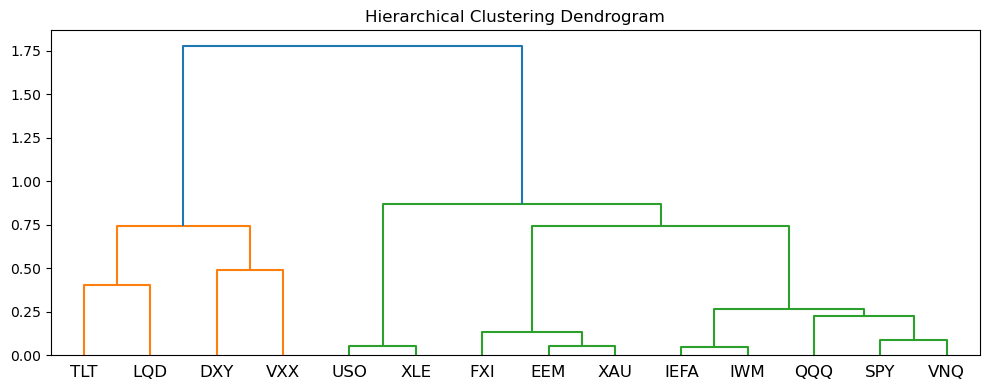

   Annualized Return  Annualized Volatility  Sharpe Ratio
0             0.0542                 0.0873        0.6211
   Annualized Return  Annualized Volatility  Sharpe Ratio
0             0.0058                 0.0911        0.0638


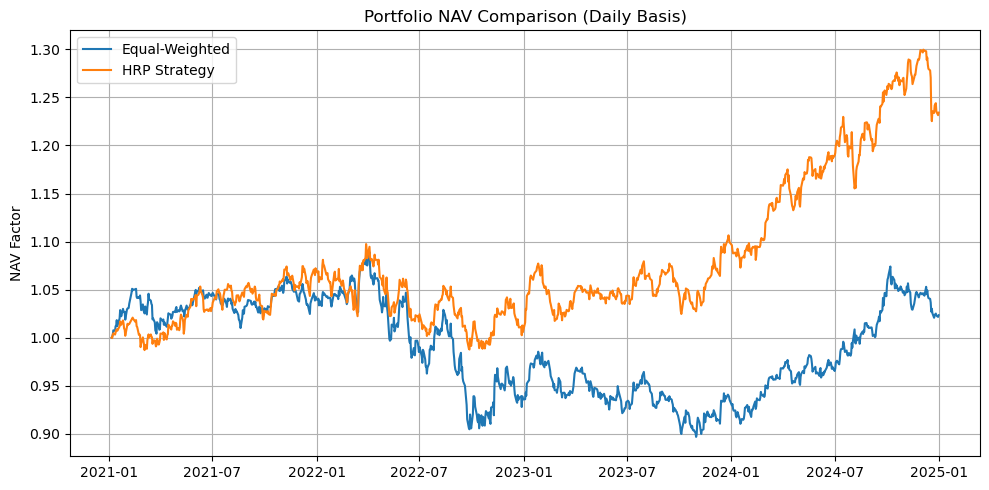

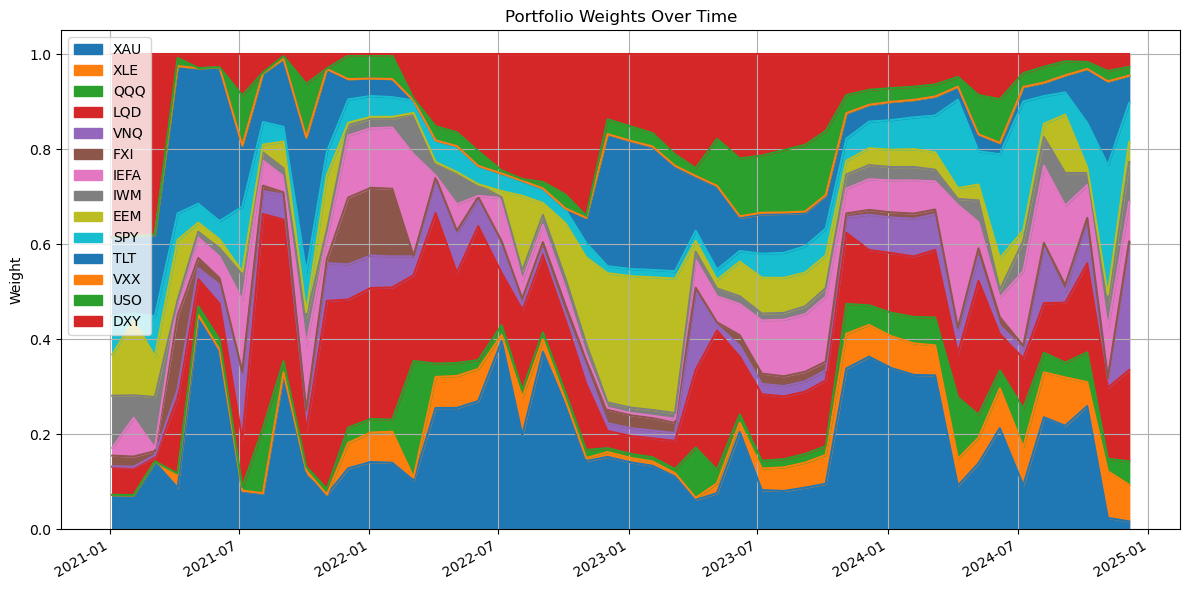

In [8]:
dendrogram_date = "2022-01-01"

# HRP backtest with dendrogram plotting at the specified date
nav, weights = backtest_portfolios(prices, dendrogram_date=dendrogram_date)

# equal-weight benchmark
equal_weight_nav = backtest_equal_weight(prices)

# start at same date
common_start_date = nav.index[0]
equal_weight_nav = equal_weight_nav.loc[common_start_date:]
nav /= nav.iloc[0]
equal_weight_nav /= equal_weight_nav.iloc[0]


# plot
plt.figure(figsize=(10, 5))
plt.plot(equal_weight_nav.index, equal_weight_nav, label='Equal-Weighted')
summary = performance_summary(nav)
print(summary)
equal_summary = performance_summary(equal_weight_nav)
print(equal_summary)
plt.plot(nav.index, nav, label='HRP Strategy')
plt.title("Portfolio NAV Comparison (Daily Basis)")
plt.ylabel("NAV Factor")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plot_weights(weights)